Cette page doit être lancée sur Kaggle, depuis la compétition pour avoir accès aux données. Sinon vous devez récupérer les données séparément.

In [79]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd 
import matplotlib.pyplot as plt# data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.image as mpimg
import math
from IPython.display import FileLink
import yaml
import random
SEED = 25
np.random.seed(SEED)
tf.random.set_seed(SEED)
OUTPUT_DIR = '/kaggle/working/outputs'
strategy = tf.distribute.MirroredStrategy()

Dans le but de pouvoir garder une trace des paramètres et hyperparamètres des modèles entrainés, un fichier `config.yml` est créé et les paramètres seront enregistrés au cours de l'exécution.

In [80]:
def save_config(dictionnaire, chemin_fichier='config.yml'):
    with open(chemin_fichier, 'w') as fichier:
        yaml.dump(dictionnaire, fichier)
    print("Fichier YAML sauvegardé avec succès.")
def read_yaml(chemin_fichier):
    if os.path.exists(chemin_fichier):
        with open(chemin_fichier, 'r') as fichier:
            contenu = yaml.safe_load(fichier)
    else:
        contenu = {}
    return contenu

In [81]:
config = {}

In [82]:
config['output_file'] = 'submission.csv' if config.get('output_file') == None else config.get('output_file')
config['BATCH_SIZE'] = 128 if config.get('BATCH_SIZE') == None else config.get('BATCH_SIZE')
config['model_file'] = 'best_model.h5'
config['epochs'] = 200 if config.get('epochs') == None else config.get('epochs')


## Affichage des images

In [83]:
directory_path = "/kaggle/input/navires-2023-la-mano/ships16x24/ships_16x24_10cat/data/"

In [84]:
def get_subdirs(directory_path):
    return next(os.walk(directory_path))[1]
def get_files_list(directory_path):
    return next(os.walk(directory_path))[2]

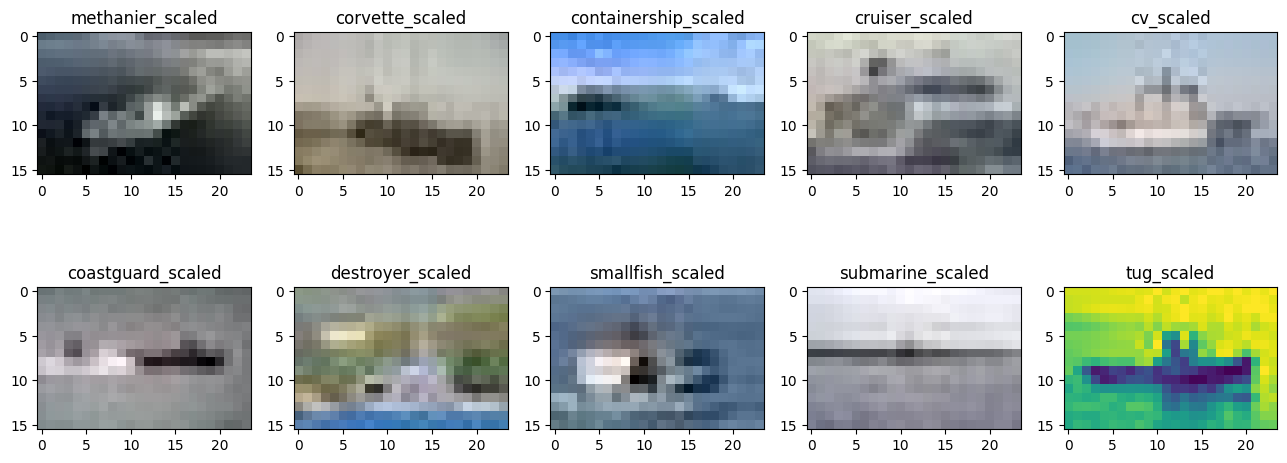

In [85]:

def display_images(directory_path,figsize=(8,8)):
    sub_dirlist = get_subdirs(directory_path)
    fig = plt.figure(figsize =figsize)
    cols,rows = 5,5
    for i in range(len(sub_dirlist)):
        sub_dir = sub_dirlist[i]
        full_path_dir = os.path.join(directory_path, sub_dir)
        img_path = random.choice(get_files_list(full_path_dir))
        img_path = os.path.join(full_path_dir,img_path)
        img = mpimg.imread(img_path)
        fig.add_subplot(rows,cols,i+1)
        plt.title(f'{sub_dir}')
        plt.imshow(img)  
    plt.show()
figsize=(16,16)
display_images(directory_path,figsize)

## Générer le dataset depuis les images

cf https://keras.io/api/data_loading/image/ et 
https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [86]:
ds_train, ds_val = tf.keras.utils.image_dataset_from_directory(directory_path, labels='inferred',subset='both',shuffle=True,validation_split=0.2,seed=SEED,image_size=(16,24), batch_size=config['BATCH_SIZE'])
ds_train

Found 35515 files belonging to 10 classes.
Using 28412 files for training.
Using 7103 files for validation.


<BatchDataset element_spec=(TensorSpec(shape=(None, 16, 24, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

## Résultat à soumettre

In [87]:
class MyCustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, patience=0,**kwargs):
        self.patience = patience
        self.counter = 0
        self.min_val_loss = float('inf')
        self.model_file_path = kwargs['model_file']
        

    def on_epoch_end(self, epoch, logs=None):
        
        val_loss = logs.get('val_loss')
        if (val_loss < self.min_val_loss):
            self.min_val_loss = val_loss
            print(f'\nNew Mininimum for validation loss: {self.min_val_loss}')
            print(f'Saving {self.model_file_path}, {epoch = }')
            self.model.save(os.path.join(self.model_file_path))

In [88]:
def test_phase(model):
    file_name = config['output_file']
    X_test = np.load('/kaggle/input/navires-2023-la-mano/test.npy', allow_pickle=True)
    X_test = X_test.astype('float32')
    res = model.predict(X_test).argmax(axis=1)
    df = pd.DataFrame({"Category":res})
    df.to_csv(os.path.join(file_name), index_label="Id")

def save_history(model,history):
    history_df = pd.DataFrame(history.history)
    hist_file_name = f"history_{model.name}.csv"
    history_df.to_csv(os.path.join(hist_file_name))

def save_model(model):
    model_file_name = f"{model.name}.h5"
    model.save(os.path.join(model_file_name))

## Créer le modèle

In [89]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout,Flatten, Dense, BatchNormalization, Rescaling, LeakyReLU,AveragePooling2D,RandomFlip,RandomRotation, Rescaling
from tensorflow.keras.models import load_model

def build_model(input_shape=(16, 24, 3), num_classes=10) -> Model:
    model = Sequential([
        
        Conv2D(64, 5, padding='same', input_shape=input_shape,activation='relu'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        Dropout(0.45),
        #MaxPooling2D(pool_size=(2, 2)),
        
        Conv2D(128, (3, 3), padding='same',activation='relu'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        
        Conv2D(128, (3, 3), padding='same',activation='relu'),
        LeakyReLU(alpha=0.1),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.7),
        
        Flatten(),
        Dense(256,activation='relu'),
        LeakyReLU(alpha=0.6),
        BatchNormalization(),
        Dropout(0.675),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model
with strategy.scope():
    model = build_model()
config['model_config'] = model.get_config()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 24, 64)        4864      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 24, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 16, 24, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 16, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 24, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 24, 128)       0         
                                                        

## Lancer le modèle

In [90]:
def plot_history(history):
    history_df = pd.DataFrame(history.history)
    history_df[['val_accuracy', 'accuracy']].plot()
    plt.show()
    history_df[['loss','val_loss']].plot()
    plt.show()

Epoch 1/2


/opt/conda/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


222/222 [==============================] - ETA: 0s - loss: 2.7357 - accuracy: 0.2263
New Mininimum for validation loss: 1.9356454610824585
Saving best_model.h5, epoch = 0
222/222 [==============================] - 110s 473ms/step - loss: 2.7357 - accuracy: 0.2263 - val_loss: 1.9356 - val_accuracy: 0.3125 - lr: 0.0010
Epoch 2/2
222/222 [==============================] - ETA: 0s - loss: 2.0208 - accuracy: 0.3278
New Mininimum for validation loss: 1.7926177978515625
Saving best_model.h5, epoch = 1
116/116 [==============================] - 4s 25ms/step


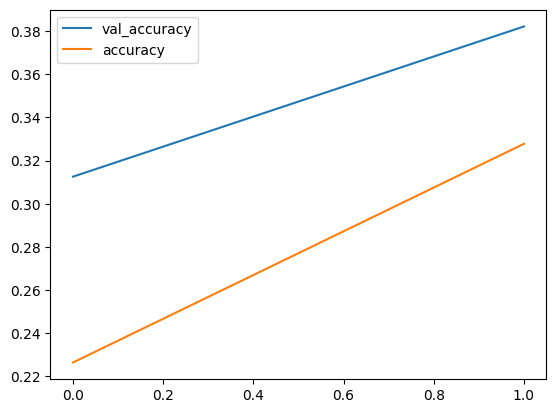

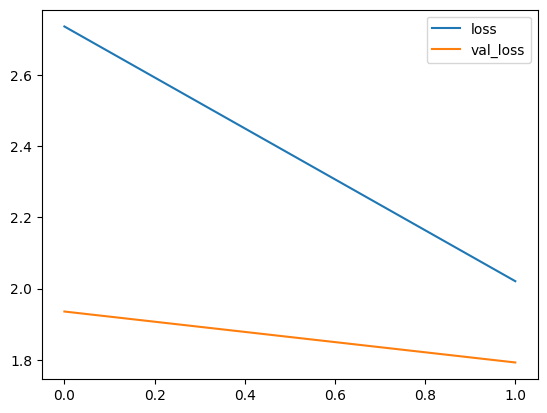

In [91]:
BEST_MODEL_FILE_NAME = 'model.h5'
def train_and_test(model=None,**kwargs):
    callbacks = []
    epochs = kwargs['epochs']
    callbacks.append(MyCustomCallback(**kwargs))
    callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",factor=0.8))
    callbacks.append(tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_FILE_NAME))
    if model is None:
        model = build_model() 
    history = model.fit(ds_train,epochs=epochs,validation_data=ds_val,callbacks=callbacks)
    test_phase(model)
    save_model(model)
    save_history(model,history)
    return history

history = train_and_test(model,**config)
model = load_model(BEST_MODEL_FILE_NAME)
plot_history(history)


In [92]:
test_phase(model)
FileLink(config['output_file'])

116/116 [==============================] - 3s 26ms/step


/kaggle/working/submission.csv

In [93]:
save_config(config,'config.yml')

Fichier YAML sauvegardé avec succès.


In [94]:
!rm -rf ships32/

In [95]:
print("Nombre de couches : ", len(model.layers))

Nombre de couches :  20
